<h1>PREDICTING USED CAR PRICE</h1>

<h3>Importing the required Library</h3>

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from sklearn.tree import export_graphviz
from mpl_toolkits.mplot3d import Axes3D
import pydot
from mpl_toolkits import mplot3d
import seaborn as sns
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,RidgeCV
from sklearn.linear_model import Lasso,LassoCV
import xgboost as xgb
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import pairwise_distances
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
sns.set_theme(style="darkgrid")
from sklearn import metrics
plt.style.use('seaborn-dark')
%matplotlib inline

<h4>Reading the csv</h4>

In [2]:
df = pd.read_csv('vehicles.csv')

<h4>Viewing the first 5 rows</h4>

In [3]:
df.head(5)

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


**Droping some features that will not be of help**

In [4]:
df = df.drop(columns=['id','posting_date','url','image_url', 'lat', 'county', 'long','state', 'region_url', 'description', 'region', 'VIN'], axis=1)

<h4>View the info</h4>

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   cylinders     249202 non-null  object 
 6   fuel          423867 non-null  object 
 7   odometer      422480 non-null  float64
 8   title_status  418638 non-null  object 
 9   transmission  424324 non-null  object 
 10  drive         296313 non-null  object 
 11  size          120519 non-null  object 
 12  type          334022 non-null  object 
 13  paint_color   296677 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 45.6+ MB


<h4>The shape of our target (Price)</h4>

In [6]:
df[df.price == 0].shape

(32895, 14)

<h4>The shape of the whole dataset</h4>

In [7]:
df.shape

(426880, 14)

<h4>Visualizing Outliers</h4>

<AxesSubplot:>

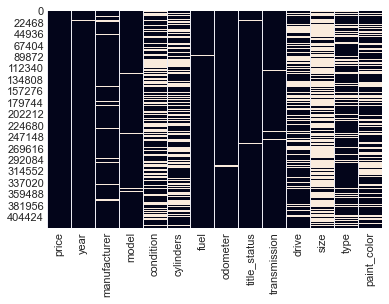

In [8]:
sns.heatmap(df.isnull(), cbar=False)

<AxesSubplot:>

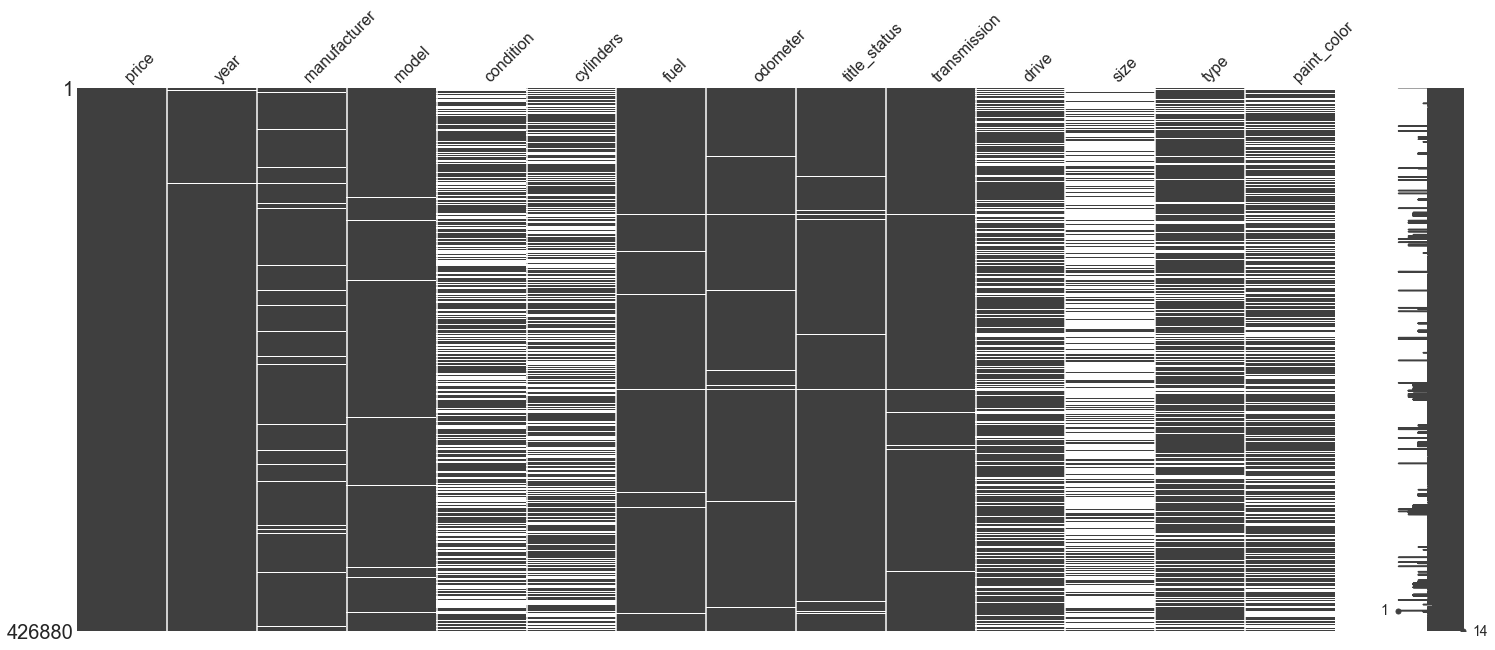

In [9]:
msno.matrix(df)

<AxesSubplot:>

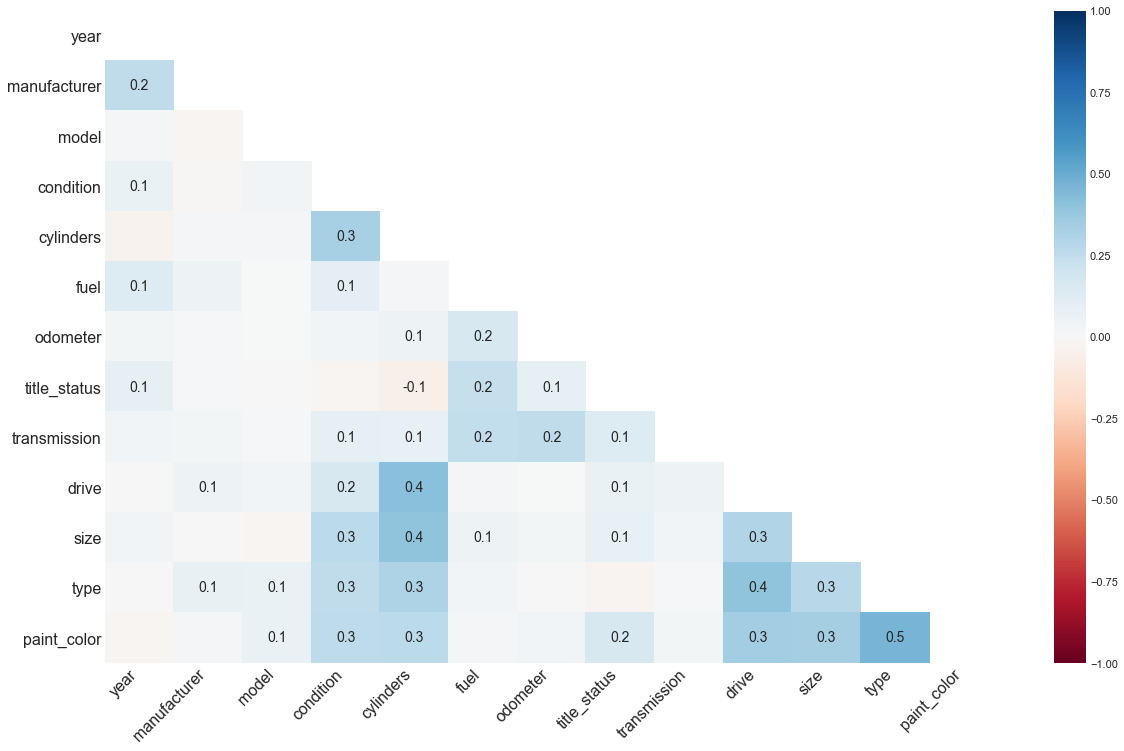

In [10]:
msno.heatmap(df)

<h4>Summary of the number of Null values and its percentage with respect to each features</h4>

In [11]:
null_values=df.isnull().sum()
null_values=pd.DataFrame(null_values,columns=['null'])
i=1
sum_total=len(df)
null_values['percent']=null_values['null']/sum_total
round(null_values*100,3).sort_values('percent',ascending=False)

,null,percent
size,30636100,71.767
cylinders,17767800,41.622
condition,17410400,40.785
drive,13056700,30.586
paint_color,13020300,30.501
type,9285800,21.753
manufacturer,1764600,4.134
title_status,824200,1.931
model,527700,1.236
odometer,440000,1.031


<h4>From the above we discovered that there are some of the features with very low percentage.</h4>

In [12]:
# sns.displot(data=df, x="price")

Viewing outliers when comparing odometer with the price

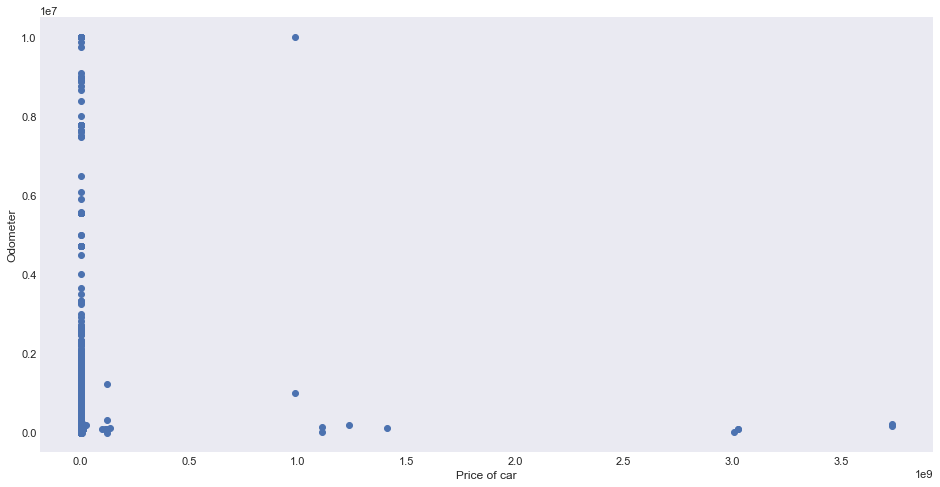

In [13]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df['price'], df['odometer'])
ax.set_xlabel('Price of car')
ax.set_ylabel('Odometer')
plt.show()

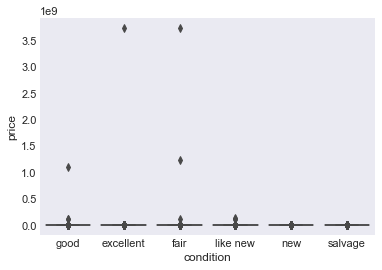

In [14]:
ax = sns.boxplot(x="condition", y="price", data=df)

<h2>Data Cleaning</h2>

<h4>Describing the target(price)</h4>

In [15]:
print(df['price'].skew())
df['price'].describe()

254.40693228580142


count    4.268800e+05
mean     7.519903e+04
std      1.218228e+07
min      0.000000e+00
25%      5.900000e+03
50%      1.395000e+04
75%      2.648575e+04
max      3.736929e+09
Name: price, dtype: float64

<h4>Too high skewness, we have to drop some data to be able to avoid skewness</h4>

<h4>Let us see the number of cars that has price above 150,000</h4>

In [16]:
df[df.price > 150000].shape

(196, 14)

<h4>Let us see the number of cars that has price below 500</h4>

In [17]:
df[df.price < 500].shape

(42094, 14)

<h4>Altogether, we have:</h4>

In [18]:
df=df[(df.price < 150000) & (df.price >= 500 )]
df.shape

(384579, 14)

<h4>Checking Odometer below 800</h4>

In [19]:
df[df.odometer < 800].shape

(7443, 14)

<h4>Checking Odometer above 300,000</h4>

In [20]:
df[df.odometer > 300000]

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color
455,22500,1929.0,ford,NaN,NaN,NaN,gas,9999999.0,clean,automatic,NaN,NaN,NaN,NaN
527,5500,2001.0,ford,e350 van,fair,NaN,diesel,340000.0,clean,automatic,fwd,NaN,van,white
562,27990,2014.0,ram,2500 4x4,like new,6 cylinders,diesel,2222222.0,clean,automatic,4wd,full-size,truck,white
616,17990,2018.0,ford,edge sel,like new,6 cylinders,gas,1111111.0,clean,automatic,fwd,mid-size,SUV,blue
932,2900,1999.0,lexus,gs400,good,8 cylinders,gas,378000.0,clean,automatic,NaN,full-size,sedan,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426306,4999,1999.0,ford,f350 crew cab,good,10 cylinders,gas,375400.0,clean,automatic,4wd,NaN,NaN,black
426377,8600,2005.0,ford,f350,good,8 cylinders,diesel,305000.0,clean,automatic,4wd,full-size,truck,blue
426449,5500,2013.0,ford,expedition el,NaN,NaN,gas,383000.0,clean,automatic,4wd,NaN,NaN,NaN
426505,8995,2016.0,ford,expedition el,NaN,6 cylinders,gas,388000.0,clean,automatic,4wd,NaN,NaN,NaN


<h4>Using the data of cars having Odometer between 800 to 300,000 and manufactured after 1980</h4>

In [21]:
df=df[(df.odometer < 300000) & (df.odometer > 1000)]
df=df[df.year>1980]
df.shape

(363512, 14)

In [22]:
null_values=df.isnull().sum()
null_values=pd.DataFrame(null_values,columns=['null'])
i=1
sum_tot=len(df)
null_values['percent']=null_values['null']/sum_tot
round(null_values*100,3).sort_values('percent',ascending=False)

,null,percent
size,26139500,71.908
cylinders,14837000,40.816
condition,13741700,37.803
drive,10881200,29.934
paint_color,10317700,28.383
type,7519000,20.684
manufacturer,1123400,3.090
title_status,605200,1.665
model,336700,0.926
fuel,205700,0.566


<h4>Now, Let us deal with the condition</h4>

In [23]:
df['condition'].isnull().sum()

137417

<h4>Let us see the number of cars from 2016 and above</h4>

In [24]:
df.loc[(df['year'] >= 2016)]['condition'].isnull().sum()

48891

In [25]:
df.condition.value_counts()

good         113573
excellent     87289
like new      18636
fair           5486
new             651
salvage         460
Name: condition, dtype: int64

<h4>Since we have very few new, we can categorize cars made from 2016 to 2018 as "like new" and 2018 above as "new"</h4>

In [26]:
df.loc[df.year>=2018, 'condition'] = df.loc[df.year>=2018, 'condition'].fillna('new')
df.loc[df.year>=2016, 'condition'] = df.loc[df.year>=2016, 'condition'].fillna('like new')

**Counting all over again the values in conditions**

In [27]:
df.condition.value_counts()

good         113573
excellent     87289
like new      42493
new           25685
fair           5486
salvage         460
Name: condition, dtype: int64

**Using Odometer to determine the condition**

In [28]:
excellent_mean = df[df['condition'] == 'excellent']['odometer'].mean()
good_mean = df[df['condition'] == 'good']['odometer'].mean()
like_new_mean = df[df['condition'] == 'like new']['odometer'].mean()
salvage_mean = df[df['condition'] == 'salvage']['odometer'].mean()
fair_mean = df[df['condition'] == 'fair']['odometer'].mean()

**Getting the average of condition using Odometer**

In [29]:
print('Like new average odometer:', round( like_new_mean,3))
print('Excellent average odometer:', round( excellent_mean,3))
print('Good average odometer:', round( good_mean,3))
print('Fair average odometer:', round( fair_mean,3))
print('Salvage average odometer:', round( salvage_mean,3))

Like new average odometer: 76347.729
Excellent average odometer: 108880.444
Good average odometer: 76941.341
Fair average odometer: 170183.571
Salvage average odometer: 143181.03


**Now I can go ahead and fill up the condition with those values**

In [30]:

df.loc[df['odometer'] <= like_new_mean, 'condition'] = df.loc[df['odometer'] <= like_new_mean, 'condition'].fillna('like new')

df.loc[df['odometer'] >= fair_mean, 'condition'] = df.loc[df['odometer'] >= fair_mean, 'condition'].fillna('fair')

df.loc[((df['odometer'] > like_new_mean) & 
       (df['odometer'] <= excellent_mean)), 'condition'] = df.loc[((df['odometer'] > like_new_mean) & 
       (df['odometer'] <= excellent_mean)), 'condition'].fillna('excellent')

df.loc[((df['odometer'] > excellent_mean) & 
       (df['odometer'] <= good_mean)), 'condition'] = df.loc[((df['odometer'] > excellent_mean) & 
       (df['odometer'] <= good_mean)), 'condition'].fillna('good')

df.loc[((df['odometer'] > good_mean) & 
       (df['odometer'] <= fair_mean)), 'condition'] = df.loc[((df['odometer'] > good_mean) & 
       (df['odometer'] <= fair_mean)), 'condition'].fillna('salvage')

In [31]:
null_values=df.isnull().sum()
null_values=pd.DataFrame(null_values,columns=['null'])
i=1
sum_tot=len(df)
null_values['percent']=null_values['null']/sum_tot
round(null_values*100,3).sort_values('percent',ascending=False)

,null,percent
size,26139500,71.908
cylinders,14837000,40.816
drive,10881200,29.934
paint_color,10317700,28.383
type,7519000,20.684
manufacturer,1123400,3.090
title_status,605200,1.665
model,336700,0.926
fuel,205700,0.566
transmission,143800,0.396


**We can use fillna for the rest of the features**

In [32]:
df['transmission'] = df['transmission'].fillna(method='ffill')
df['title_status'] = df['title_status'].fillna(method='ffill')
df['fuel'] = df['fuel'].fillna(method='ffill')
df['size'] = df['size'].fillna(method='ffill')
df['paint_color'] = df['paint_color'].fillna(method='ffill')
df['drive'] = df['drive'].fillna(method='ffill')
df['manufacturer'] = df['manufacturer'].fillna(method='ffill')
df['type'] = df['type'].fillna(method='ffill')
df['model'] = df['model'].fillna(method='ffill')
df['cylinders'] = df['cylinders'].fillna(method='ffill')

**Checking the null details all over**

In [33]:
null_values=df.isnull().sum()
null_values=pd.DataFrame(null_values,columns=['null'])
i=1
sum_tot=len(df)
null_values['percent']=null_values['null']/sum_tot
round(null_values*100,3).sort_values('percent',ascending=False)

,null,percent
drive,400,0.001
size,400,0.001
price,0,0.000
year,0,0.000
manufacturer,0,0.000
model,0,0.000
condition,0,0.000
cylinders,0,0.000
fuel,0,0.000
odometer,0,0.000


**Dropping the null values for size and drive as they have very small percentage**

In [34]:
df=df.dropna(axis='columns')

**Our data should be clean now**

In [35]:
null_values=df.isnull().sum()
null_values=pd.DataFrame(null_values,columns=['null'])
i=1
sum_tot=len(df)
null_values['percent']=null_values['null']/sum_tot
round(null_values*100,3).sort_values('percent',ascending=False)

,null,percent
price,0,0.0
year,0,0.0
manufacturer,0,0.0
model,0,0.0
condition,0,0.0
cylinders,0,0.0
fuel,0,0.0
odometer,0,0.0
title_status,0,0.0
transmission,0,0.0


**Visualizing our cleaned data**

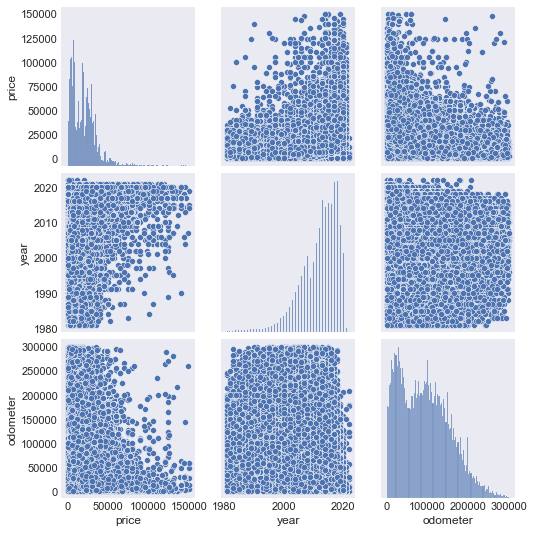

In [36]:
sns.pairplot(df)

**Sorting using the price and year**

In [41]:
df.set_index(['price', 'year']).sample(10)

,,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,type,paint_color
price,year,,,,,,,,,,
8950,2007.0,honda,pilot,salvage,6 cylinders,gas,156918.0,clean,automatic,SUV,white
23916,2017.0,nissan,pathfinder,like new,8 cylinders,gas,66096.0,clean,other,other,white
25590,2020.0,buick,encore gx select sport,good,6 cylinders,gas,1113.0,clean,automatic,SUV,red
19999,2011.0,ford,f150 supercab xlt,salvage,6 cylinders,gas,125200.0,clean,automatic,pickup,white
16998,2016.0,nissan,rogue sv low miles nice,excellent,8 cylinders,gas,37599.0,clean,automatic,SUV,blue
60990,2018.0,mercedes-benz,s-class s 450,good,6 cylinders,other,34765.0,clean,other,sedan,black
2200,2004.0,ford,e350 box truck,fair,8 cylinders,gas,187892.0,clean,automatic,truck,white
16500,2014.0,ford,edge sel,good,6 cylinders,gas,67700.0,clean,automatic,pickup,white
2500,2001.0,chevrolet,c3500 service truck,good,8 cylinders,gas,160000.0,clean,manual,other,white


**Sorting using the year**

In [42]:
df.sort_values('year').sample(10)

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,type,paint_color
108069,8788,2012.0,chevrolet,cruze,excellent,8 cylinders,gas,79849.0,clean,manual,sedan,white
318974,9999,2010.0,volvo,xc60,salvage,6 cylinders,gas,151000.0,clean,automatic,SUV,silver
99724,9900,2013.0,mini,cooper countryman,excellent,4 cylinders,gas,100552.0,clean,automatic,hatchback,silver
405115,24999,2018.0,acura,rdx 6-spd at awd,new,8 cylinders,gas,30556.0,clean,automatic,SUV,brown
148562,6950,2005.0,ford,ranger,fair,4 cylinders,gas,215679.0,clean,other,other,white
86553,16995,2010.0,ford,f-350 super duty dump,excellent,4 cylinders,diesel,91474.0,clean,automatic,sedan,red
197083,6999,2013.0,ford,taurus,salvage,6 cylinders,gas,136508.0,clean,automatic,sedan,silver
406604,8995,2011.0,kia,sportage,good,4 cylinders,gas,132000.0,clean,automatic,SUV,grey
31702,14999,2014.0,chevrolet,silverado 1500 work tr,salvage,6 cylinders,other,114906.0,clean,automatic,pickup,white
78084,22387,2019.0,toyota,camry,new,4 cylinders,gas,51774.0,clean,automatic,sedan,grey


In [43]:
df.describe()

,price,year,odometer
count,363512.000000,363512.000000,363512.000000
mean,19202.438838,2012.049767,94418.799561
std,14446.446052,6.276700,61067.252286
min,500.000000,1981.000000,1001.000000
25%,7900.000000,2008.000000,41002.000000
50%,15988.000000,2013.000000,90000.000000
75%,27990.000000,2017.000000,137000.000000
max,149998.000000,2022.000000,299999.000000


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363512 entries, 27 to 426879
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         363512 non-null  int64  
 1   year          363512 non-null  float64
 2   manufacturer  363512 non-null  object 
 3   model         363512 non-null  object 
 4   condition     363512 non-null  object 
 5   cylinders     363512 non-null  object 
 6   fuel          363512 non-null  object 
 7   odometer      363512 non-null  float64
 8   title_status  363512 non-null  object 
 9   transmission  363512 non-null  object 
 10  type          363512 non-null  object 
 11  paint_color   363512 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 36.1+ MB


**Viewing the number of cars based on Manufacturer**

In [45]:
df.manufacturer.value_counts()

ford               61993
chevrolet          46947
toyota             30888
honda              19481
nissan             17050
jeep               16513
ram                16109
gmc                15041
bmw                13596
dodge              11296
mercedes-benz       9894
hyundai             9244
subaru              8854
volkswagen          8263
lexus               7743
kia                 7377
audi                7198
cadillac            6323
acura               5738
chrysler            5442
buick               4982
mazda               4949
infiniti            4521
lincoln             3937
volvo               3144
mitsubishi          3049
mini                2243
rover               1937
pontiac             1917
jaguar              1845
porsche             1247
saturn              1082
mercury              959
alfa-romeo           870
tesla                855
fiat                 742
harley-davidson      124
ferrari               69
aston-martin          21
datsun                17


**Saving our Cleaned data**

In [133]:
df.to_csv('vehicles_cleaned.csv', index=False)

**Now we will work on the cleaned data**

In [46]:
df.head(5)

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,type,paint_color
27,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,pickup,white
28,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,pickup,blue
29,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,pickup,red
30,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,pickup,red
31,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,truck,black


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363512 entries, 27 to 426879
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         363512 non-null  int64  
 1   year          363512 non-null  float64
 2   manufacturer  363512 non-null  object 
 3   model         363512 non-null  object 
 4   condition     363512 non-null  object 
 5   cylinders     363512 non-null  object 
 6   fuel          363512 non-null  object 
 7   odometer      363512 non-null  float64
 8   title_status  363512 non-null  object 
 9   transmission  363512 non-null  object 
 10  type          363512 non-null  object 
 11  paint_color   363512 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 36.1+ MB


**First, I will do a preprocessing with SciKit Learn**

**Label Processing**

In [48]:
from sklearn import preprocessing
pre = preprocessing.LabelEncoder()

df[['manufacturer', 'model', 'condition', 'cylinders','fuel','title_status', 'transmission','year','type','paint_color']] = df[['manufacturer', 'model', 'condition','cylinders', 'fuel','title_status', 'transmission','year','type','paint_color']].apply(pre.fit_transform)

**Split Train and Test data**

In [49]:
from sklearn.model_selection import train_test_split

y= df.price
X= df.drop('price',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(290809, 11) (290809,)
(72703, 11) (72703,)


**Min-max scaler:**

For each value in a feature, MinMaxScaler subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum.

In [50]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()   
X_train= sc.fit_transform(X_train)
X_test= sc.transform(X_test)

In [51]:
X_train

array([[0.65853659, 0.36585366, 0.38732742, ..., 0.        , 0.66666667,
        0.        ],
       [0.87804878, 0.24390244, 0.56640368, ..., 0.        , 0.41666667,
        0.90909091],
       [0.90243902, 0.41463415, 0.41683103, ..., 0.        , 0.75      ,
        0.09090909],
       ...,
       [0.68292683, 0.31707317, 0.80029586, ..., 0.        , 1.        ,
        0.72727273],
       [0.75609756, 0.31707317, 0.67784352, ..., 0.        , 0.        ,
        0.72727273],
       [0.80487805, 0.17073171, 0.83041584, ..., 1.        , 0.66666667,
        0.18181818]])

 <h3>Random Forest</h3>

In [52]:
Reg = RandomForestRegressor(n_estimators=20, random_state=0)
Reg.fit(X_train, y_train)
y_pred = Reg.predict(X_test)

In [53]:
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred),3))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred),3))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3))

Mean Absolute Error: 2410.212
Mean Squared Error: 29212092.587
Root Mean Squared Error: 5404.821


**Let's increase number of estimator from 20 to 300**

In [54]:
from sklearn.ensemble import RandomForestRegressor
Reg = RandomForestRegressor(n_estimators=300, random_state=0)
Reg.fit(X_train, y_train)
y_pred = Reg.predict(X_test)

In [55]:
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred),3))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred),3))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3))

Mean Absolute Error: 2323.871
Mean Squared Error: 27957030.011
Root Mean Squared Error: 5287.441


**With more trees, the model accuracy has increased slightly**

**Visualization**

In [58]:
rf= Reg
features= df.drop('price', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

Rnd = RandomForestRegressor(n_estimators=10, max_depth = 3)
Rnd.fit(X_train, y_train)
# Extract the small tree
tree = Rnd.estimators_[5]
# Save the tree as a png image
export_graphviz(tree, out_file = 'small_tree.png',
                feature_names = feature_list, rounded = True, precision = 1, proportion = False, filled= True)

graph.write_png('small_tree.png');


In [ ]:
from IPython.display import Image
Image(filename = 'small_tree.png')

**Features Relevance**

In [59]:
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: year                 Importance: 0.4
Variable: odometer             Importance: 0.15
Variable: model                Importance: 0.14
Variable: fuel                 Importance: 0.1
Variable: manufacturer         Importance: 0.06
Variable: cylinders            Importance: 0.05
Variable: type                 Importance: 0.04
Variable: condition            Importance: 0.02
Variable: paint_color          Importance: 0.02
Variable: title_status         Importance: 0.01
Variable: transmission         Importance: 0.01


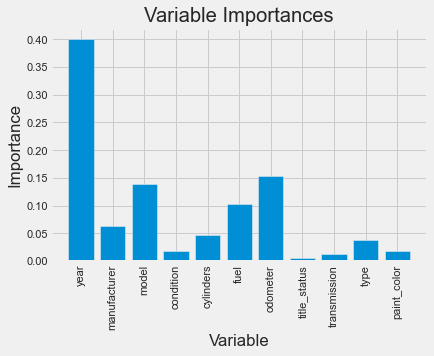

In [60]:
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

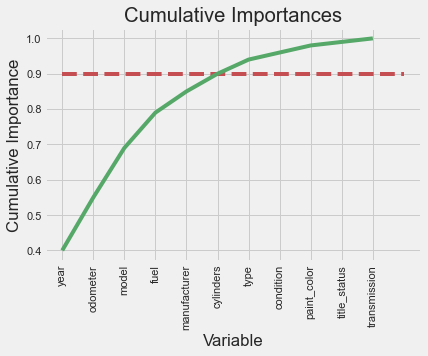

In [61]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 90% of importance retained
plt.hlines(y = 0.90, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance');
plt.title('Cumulative Importances');

In [62]:
# Find number of features for cumulative importance of 90%

# Add 1 because Python is zero-indexed
print('Number of features for 90% importance:', np.where(cumulative_importances > 0.90)[0][0] + 1)

Number of features for 90% importance: 6


**New Random Forest with the most important 6 features**

In [63]:
# New random forest with only the most important variables
from sklearn.ensemble import RandomForestRegressor
random_forest_most_important = RandomForestRegressor(n_estimators=300, random_state=0)

In [64]:
# Extract the most important features
features= df.drop('price', axis = 1)

# Saving feature names for later use
rf_feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)


important_indices = [rf_feature_list.index('year'), 
                     rf_feature_list.index('odometer'), rf_feature_list.index('fuel'),
                     rf_feature_list.index('model'), rf_feature_list.index('cylinders'), rf_feature_list.index('manufacturer')]
train_important = X_train[:, important_indices]
test_important = X_test[:, important_indices]

In [65]:
# Train the random forest
random_forest_most_important.fit(train_important, y_train)

RandomForestRegressor(n_estimators=300, random_state=0)

**Make pedictions with this filtered model**

In [67]:
predictions = random_forest_most_important.predict(test_important)

In [68]:
from sklearn import metrics
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, predictions),2))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, predictions),2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, predictions)),2))

Mean Absolute Error: 2218.47
Mean Squared Error: 27237704.97
Root Mean Squared Error: 5218.98


This accuracy is slightly better than the full model. In addition, we this accuracy was obtained just by using 6 features instead of 13. Therefore, it can be considered as an improvement in both accuracy and efficiency.

# Linear Regression

In [69]:
Linear_Reg = LinearRegression()
Linear_Reg.fit(X_train, y_train)
y_pred_Linear_Reg = Linear_Reg.predict(X_test)
RMSE_Linear_Reg = np.sqrt(mse(y_test, y_pred_Linear_Reg))

In [70]:
print('Linear Regression')
print("RMSE = {:.3f}".format((RMSE_Linear_Reg)))
Linear_Reg_Accuracy = Linear_Reg.score(X_test,y_test)
print('Linear_Reg_Accuracy = {:.3f}'.format((Linear_Reg_Accuracy)))

Linear Regression
RMSE = 10558.867
Linear_Reg_Accuracy = 0.469


In [78]:
Regressor = LinearRegression()  
Regressor.fit(X_train, y_train) #training the algorithm

#To retrieve the intercept:
print(Regressor.intercept_)#For retrieving the slope:
print(Regressor.coef_)

-2052.0897750651966
[ 32526.30302649  -1047.29968769    612.0344962    2551.93045694
  16186.93938539 -15467.307296   -25391.46227581  -7364.97805018
   1824.45398009    797.29166623    441.5457319 ]


<h3>For Ordinary Least Square Regression</h3>

In [79]:
OLS_pred= Regressor.predict(X_train)

In [80]:
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_train, OLS_pred),3))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_train, OLS_pred),3))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_train, OLS_pred)),3))

Mean Absolute Error: 7456.856
Mean Squared Error: 109421021.248
Root Mean Squared Error: 10460.45


**Check performance of the OLS on test data**

In [81]:
y_pred_OLS = Regressor.predict(X_test)

In [82]:
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred_OLS),3))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred_OLS),3))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_OLS)),3))

Mean Absolute Error: 7504.505
Mean Squared Error: 111489674.656
Root Mean Squared Error: 10558.867


In [84]:
df_pred_OLS = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_OLS})
df_pred_OLS1 = df_pred_OLS.head(10)
round(df_pred_OLS1,3)

,Actual,Predicted
206191,23359,27492.125
211426,2395,3984.281
372611,27990,30497.977
417309,27500,21808.817
413079,19581,33502.360
340377,27990,31188.943
418977,33590,35311.380
422894,22487,25665.148
148680,5995,13717.357
313938,23995,25786.614


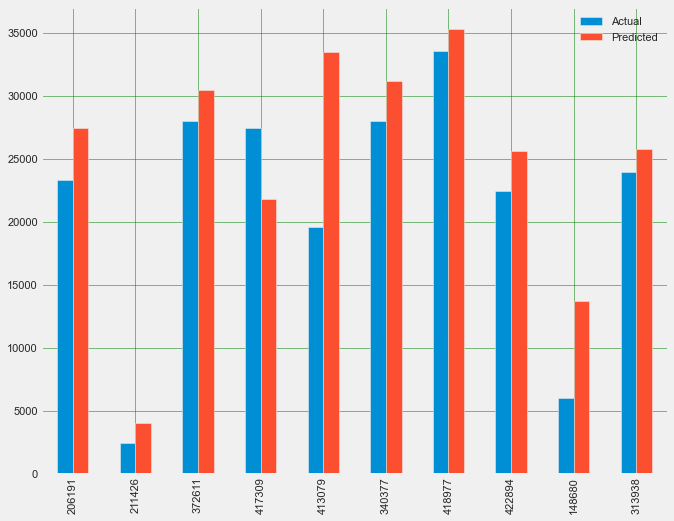

In [85]:
df_pred_OLS1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

# Ridge Regression

**Training the model**

In [86]:
Ridge_Regression = Ridge()
Ridge_Regression.fit(X_train, y_train)
y_pred_Ridge_Regression = Ridge_Regression.predict(X_test)
RMSE_Ridge_Regression = np.sqrt(mse(y_test, y_pred_Ridge_Regression))

In [87]:
print('Ridge Regression')
print("RMSE = {:.3f}".format((RMSE_Ridge_Regression)))
Ridge_Regression_Accuracy = Ridge_Regression.score(X_test,y_test)
print('Ridge_Regression_Accuracy = {:.3f}'.format((Ridge_Regression_Accuracy)))

Ridge Regression
RMSE = 10558.869
Ridge_Regression_Accuracy = 0.469


In [88]:
Regressor = LinearRegression()  
Regressor.fit(X_train, y_train) #training the algorithm

#To retrieve the intercept:
print(Regressor.intercept_)
#For retrieving the slope:
print(Regressor.coef_)

-2052.0897750651966
[ 32526.30302649  -1047.29968769    612.0344962    2551.93045694
  16186.93938539 -15467.307296   -25391.46227581  -7364.97805018
   1824.45398009    797.29166623    441.5457319 ]


In [89]:
alphas = 10**np.linspace(10,-2,200)*0.5

**Visualizing the weights of alpha**

Text(0, 0.5, 'weights')

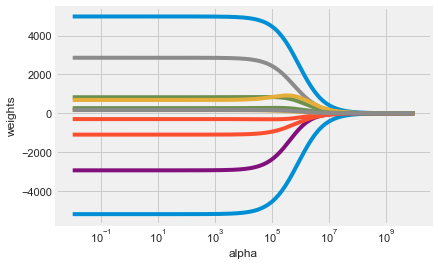

In [90]:
from sklearn.preprocessing import scale 
from sklearn.datasets import make_regression


clf= Ridge()
coefs = []

for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(scale(X_train), y_train)
    coefs.append(clf.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [91]:
from sklearn.preprocessing import scale 

Ridge_Cross_Val = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
Ridge_Cross_Val.fit(X_train, y_train)
Ridge_Cross_Val.alpha_

0.005

Now, we refit our Ridge Regression model on the whole data set, using the value of alpha that was chosen using the cross-validation, and examine the coefficient estimates.

In [92]:
# Fit a ridge regression on the training data
y_pred2 = Ridge_Cross_Val.predict(X_test)
# Use this model to predict the test data
print(pd.Series(Ridge_Cross_Val.coef_, index = X.columns))

year            32420.049815
manufacturer    -1049.622517
model             608.812148
condition        2554.676482
cylinders       16105.208862
fuel           -15364.021220
odometer       -25281.230747
title_status    -7329.933825
transmission     1841.135683
type              799.240869
paint_color       441.260733
dtype: float64


In [93]:
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred2),3))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred2),3))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred2)),3))

Mean Absolute Error: 7503.925
Mean Squared Error: 111493101.527
Root Mean Squared Error: 10559.029


Text(0.5, 1.0, 'Feature importance using Ridge Model')

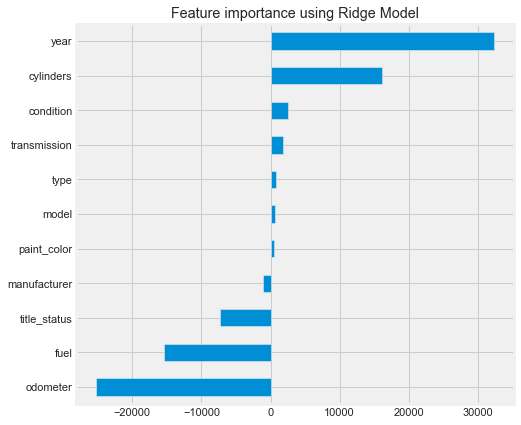

In [94]:
Ridge_Coef= pd.Series(Ridge_Cross_Val.coef_, index = X.columns)
Importance_coef = Ridge_Coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (7.0, 7.0)
Importance_coef.plot(kind = "barh")
plt.title("Feature importance using Ridge Model")

In [95]:
y_pred2 = Regressor.predict(X_test)

In [96]:
df_pred_Ridge = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred2})
df_pred_Ridge2 = df_pred_Ridge.head(10)
round(df_pred_Ridge2,3)

,Actual,Predicted
206191,23359,27492.125
211426,2395,3984.281
372611,27990,30497.977
417309,27500,21808.817
413079,19581,33502.360
340377,27990,31188.943
418977,33590,35311.380
422894,22487,25665.148
148680,5995,13717.357
313938,23995,25786.614


**Bringing the tables together to see the difference in the prediction compared to actual**

In [98]:
df_pred_OLS_Ridge = pd.DataFrame({'Actual': y_test, 'Predicted OLS': y_pred_OLS, 'Predicted Ridge': y_pred2})
df_pred_OLS_Ridge2 = df_pred_OLS_Ridge.head(10)
round(df_pred_OLS_Ridge2,3)

,Actual,Predicted OLS,Predicted Ridge
206191,23359,27492.125,27492.125
211426,2395,3984.281,3984.281
372611,27990,30497.977,30497.977
417309,27500,21808.817,21808.817
413079,19581,33502.360,33502.360
340377,27990,31188.943,31188.943
418977,33590,35311.380,35311.380
422894,22487,25665.148,25665.148
148680,5995,13717.357,13717.357
313938,23995,25786.614,25786.614


## **LASSO**

Visualizing the weights of the alphs fpr LASSO

No handles with labels found to put in legend.


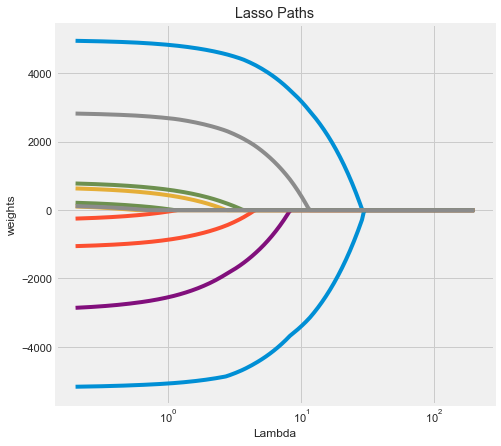

In [99]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []
alphas= np.logspace(-1,2,200)
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('Lambda')
plt.ylabel('weights')
plt.title('Lasso Paths')
plt.legend()

In [100]:
Lasso_Reg = LassoCV( alphas = None, cv = 10, max_iter = 100000, normalize = True)
Lasso_Reg.fit(X_train, y_train)
print("Best alpha using built-in LassoCV: %f" % Lasso_Reg.alpha_)
print("Best score using built-in LassoCV: %f" %Lasso_Reg.score(X_train,y_train))
coef_LASSO = pd.Series(Lasso_Reg.coef_, index = X.columns)
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, Lasso_Reg.predict(X_test))),2))

Best alpha using built-in LassoCV: 0.014868
Best score using built-in LassoCV: 0.474800
Root Mean Squared Error: 10558.85


In [101]:
y_pred_LASSO = Lasso_Reg.predict(X_test)

In [102]:
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred_LASSO),3))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred_LASSO),3))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_LASSO)),3))

Mean Absolute Error: 7504.793
Mean Squared Error: 111489314.252
Root Mean Squared Error: 10558.85


In [103]:
Lasso_Reg.alpha_

0.014868478675187584

In [104]:
coef_LASSO

year            32499.027092
manufacturer    -1020.344509
model             579.766284
condition        2530.781939
cylinders       16160.020432
fuel           -15405.058724
odometer       -25373.421773
title_status    -7318.529454
transmission     1804.492886
type              775.339361
paint_color       422.418193
dtype: float64

Text(0.5, 1.0, 'Feature importance using Lasso Model')

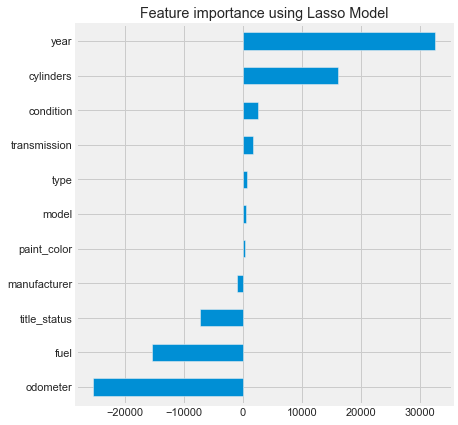

In [105]:
important_coef_LASSO = coef_LASSO.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0, 7.0)
important_coef_LASSO.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [107]:
lasso_t = Lasso(alpha=300, max_iter=10e5)
lasso_t.fit(X_train,y_train)
train_score_t=lasso_t.score(X_train,y_train)
test_score_t=lasso_t.score(X_test,y_test)
coeff_used_t = np.sum(lasso_t.coef_!=0)
print ("training score for alpha=200:", train_score_t)
print ("test score for alpha =200: ", test_score_t)
print ("number of features used: for alpha =300: ", coeff_used_t)

training score for alpha=200: 0.4138615523794448
test score for alpha =200:  0.409077037230387
number of features used: for alpha =300:  6


In [108]:
df_pred_LASSO = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_LASSO})
df_pred_LASSO2 = df_pred_LASSO.head(10)
round(df_pred_LASSO2,3)

,Actual,Predicted
206191,23359,27487.175
211426,2395,4038.362
372611,27990,30467.434
417309,27500,21807.438
413079,19581,33475.598
340377,27990,31165.664
418977,33590,35271.601
422894,22487,25629.336
148680,5995,13702.136
313938,23995,25754.163


In [109]:
df_pred_OLS_Ridge_LASSO = pd.DataFrame({'Actual': y_test, 'Predicted OLS': y_pred_OLS, 'Predicted Ridge': y_pred2, 'Predicted LASSO': y_pred_LASSO})
df_pred_OLS_Ridge_LASSO2 = df_pred_OLS_Ridge_LASSO.head(10)
round(df_pred_OLS_Ridge_LASSO2,3)

,Actual,Predicted OLS,Predicted Ridge,Predicted LASSO
206191,23359,27492.125,27492.125,27487.175
211426,2395,3984.281,3984.281,4038.362
372611,27990,30497.977,30497.977,30467.434
417309,27500,21808.817,21808.817,21807.438
413079,19581,33502.360,33502.360,33475.598
340377,27990,31188.943,31188.943,31165.664
418977,33590,35311.380,35311.380,35271.601
422894,22487,25665.148,25665.148,25629.336
148680,5995,13717.357,13717.357,13702.136
313938,23995,25786.614,25786.614,25754.163


# KNN

In [111]:
RMSE_val2 = [] #to store rmse values for different k
for k in range(15):
    k += 1
    model = neighbors.KNeighborsRegressor(n_neighbors = k)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mse(y_test, pred)) #calculate rmse
    RMSE_val2.append(error) #store rmse values
    print('RMSE value for k= ' , k , 'is:', error)

RMSE value for k=  1 is: 7919.881312253285
RMSE value for k=  2 is: 7368.028880328975
RMSE value for k=  3 is: 7280.774300597109
RMSE value for k=  4 is: 7278.1614608206355
RMSE value for k=  5 is: 7317.8415812162775
RMSE value for k=  6 is: 7347.070127878025
RMSE value for k=  7 is: 7378.468845125162
RMSE value for k=  8 is: 7418.417084336543
RMSE value for k=  9 is: 7453.540083997022
RMSE value for k=  10 is: 7481.5607013050385
RMSE value for k=  11 is: 7505.849151351051
RMSE value for k=  12 is: 7529.291991741834
RMSE value for k=  13 is: 7553.832124744227
RMSE value for k=  14 is: 7580.925305476372
RMSE value for k=  15 is: 7604.187297344779


<AxesSubplot:>

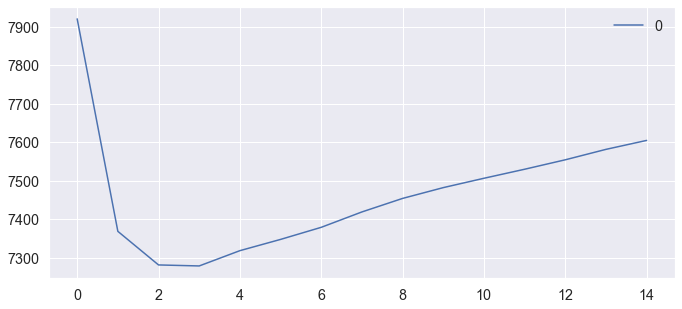

In [112]:
#plotting the rmse values against k values
import seaborn as sns

sns.set(font_scale=1.3)

curve = pd.DataFrame(RMSE_val2) #elbow curve 
curve.plot(figsize=(10,5))

This means that we can make the best prediction by looking at two to four nearest neighbors of a data point. The number depends on the insight of the researcher.

**Generating Model for K=4**

In [113]:
#Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
KNN = KNeighborsClassifier(n_neighbors=4)

#Train the model using the training sets
KNN.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_KNN = KNN.predict(X_test)

In [114]:
y_pred_KNN

array([18995,  1995, 22590, ..., 14500, 29990,  5500], dtype=int64)

**Another way of Visualizing the K value**

In [115]:
Ks = 13
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.39063037, 0.33056408, 0.30528314, 0.28780105, 0.27554571,
       0.26528479, 0.25644059, 0.24824285, 0.24159938, 0.23501093,
       0.22972917, 0.22477752])

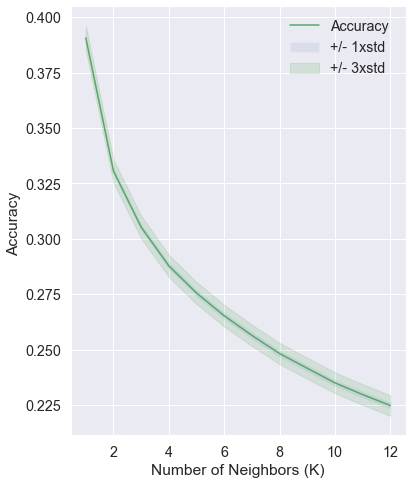

In [116]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [117]:
# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_KNN))

Accuracy: 0.28780105360163954


In [118]:
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred_KNN),2))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred_KNN),2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_KNN)),2))
Accuracy = KNN.score(X_test,y_test)
print("Accuracy:", round(Accuracy*100,3),'%')

Mean Absolute Error: 4613.79
Mean Squared Error: 86795004.02
Root Mean Squared Error: 9316.38
Accuracy: 28.78 %


In [119]:
df_pred_KNN = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_KNN})
df_pred_KNN2 = df_pred_KNN.head(10)
round(df_pred_KNN2,3)

,Actual,Predicted
206191,23359,18995
211426,2395,1995
372611,27990,22590
417309,27500,18500
413079,19581,22985
340377,27990,27990
418977,33590,32990
422894,22487,22487
148680,5995,4500
313938,23995,12895


In [120]:
df_pred_OLS_Ridge_LASSO_KNN = pd.DataFrame({'Actual': y_test, 'Predicted OLS': y_pred_OLS, 'Predicted Ridge': y_pred2, 'Predicted LASSO': y_pred_LASSO,'Predicted KNN': y_pred_KNN})
df_pred_OLS_Ridge_LASSO_KNN2 = df_pred_OLS_Ridge_LASSO_KNN.head(10)
round(df_pred_OLS_Ridge_LASSO_KNN2,3)

,Actual,Predicted OLS,Predicted Ridge,Predicted LASSO,Predicted KNN
206191,23359,27492.125,27492.125,27487.175,18995
211426,2395,3984.281,3984.281,4038.362,1995
372611,27990,30497.977,30497.977,30467.434,22590
417309,27500,21808.817,21808.817,21807.438,18500
413079,19581,33502.360,33502.360,33475.598,22985
340377,27990,31188.943,31188.943,31165.664,27990
418977,33590,35311.380,35311.380,35271.601,32990
422894,22487,25665.148,25665.148,25629.336,22487
148680,5995,13717.357,13717.357,13702.136,4500
313938,23995,25786.614,25786.614,25754.163,12895


# XGBOOST

In [122]:
XG_REG = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 20, n_estimators = 20)
XG_REG.fit(X_train,y_train)

pred_XGB = XG_REG.predict(X_test)
RMSE_XGB = np.sqrt(mse(y_test, pred_XGB))
print("RMSE: %f" % (RMSE_XGB))

[21:41:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 9985.195052


In [123]:
# fit model
XG_REG = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

XG_REG.fit(X_train,y_train)

predictions = XG_REG.predict(X_test)

[21:41:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


In [124]:
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, predictions),))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, predictions),3))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, predictions)),3))

Mean Absolute Error: 8489
Mean Squared Error: 166749946.662
Root Mean Squared Error: 12913.17


In [125]:
df_pred_XGB = pd.DataFrame({'Actual': y_test, 'Predicted': pred_XGB})
df_pred_XGB2 = df_pred_XGB.head(10)
round(df_pred_XGB2,3)

,Actual,Predicted
206191,23359,19362.839844
211426,2395,5582.981934
372611,27990,22107.144531
417309,27500,17327.490234
413079,19581,27355.292969
340377,27990,24141.183594
418977,33590,24434.376953
422894,22487,20143.759766
148680,5995,11015.545898
313938,23995,21595.439453


In [126]:
df_pred_OLS_Ridge_LASSO_KNN_XGB = pd.DataFrame({'Actual': y_test, 'Predicted OLS': y_pred_OLS, 'Predicted Ridge': y_pred2, 'Predicted LASSO': y_pred_LASSO,'Predicted KNN': y_pred_KNN, 'Predicted XGB': pred_XGB})
df_pred_OLS_Ridge_LASSO_KNN_XGB2 = df_pred_OLS_Ridge_LASSO_KNN_XGB.head(10)
round(df_pred_OLS_Ridge_LASSO_KNN_XGB2,3)

,Actual,Predicted OLS,Predicted Ridge,Predicted LASSO,Predicted KNN,Predicted XGB
206191,23359,27492.125,27492.125,27487.175,18995,19362.839844
211426,2395,3984.281,3984.281,4038.362,1995,5582.981934
372611,27990,30497.977,30497.977,30467.434,22590,22107.144531
417309,27500,21808.817,21808.817,21807.438,18500,17327.490234
413079,19581,33502.360,33502.360,33475.598,22985,27355.292969
340377,27990,31188.943,31188.943,31165.664,27990,24141.183594
418977,33590,35311.380,35311.380,35271.601,32990,24434.376953
422894,22487,25665.148,25665.148,25629.336,22487,20143.759766
148680,5995,13717.357,13717.357,13702.136,4500,11015.545898
313938,23995,25786.614,25786.614,25754.163,12895,21595.439453


**Visaualizing the above**

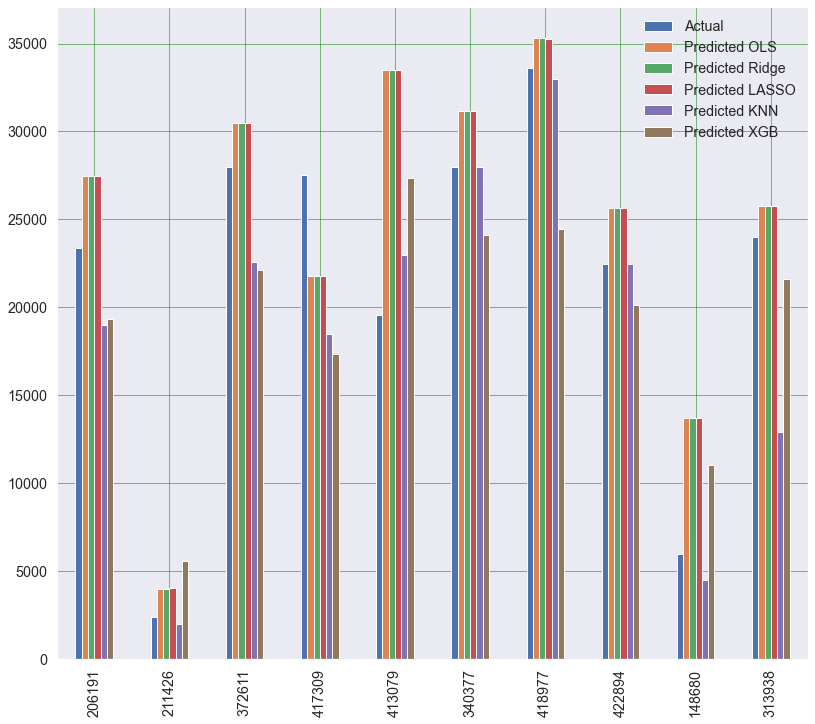

In [129]:
df_pred_OLS_Ridge_LASSO_KNN_XGB2.plot(kind='bar',figsize=(12,12))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

<h2>About the Authors:</h2>
<a href="https://www.linkedin.com/in/john-temidayo-falade-589b16a0/">John Temidayo Falade</a>  has a Masters in Mathematics, his research focused on using machine learning, data analysis.